In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import *
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
import os
os.chdir("..")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train[train.drop(columns = ['time','Y1','Y2']).isna().any(axis=1)]

,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,Y1,Y2


Correlation between time and Y1: -0.00031297561059577745
Correlation between time and Y2: 0.08097388986728499


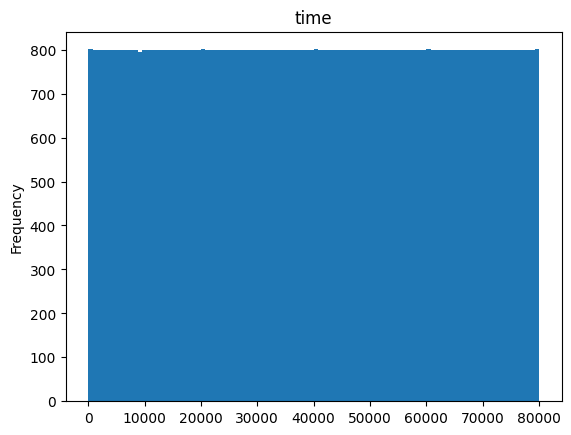

Correlation between time and Y1: -0.00031297561059577745
Correlation between time and Y2: 0.08097388986728499


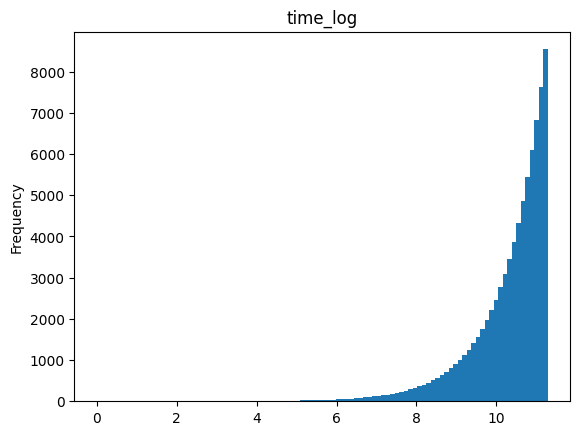

Correlation between A and Y1: -0.002307964278712182
Correlation between A and Y2: 0.6092089648221655


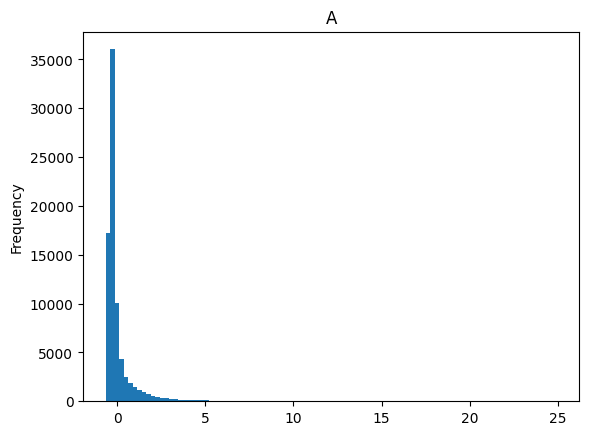

Correlation between A and Y1: -0.002307964278712182
Correlation between A and Y2: 0.6092089648221655


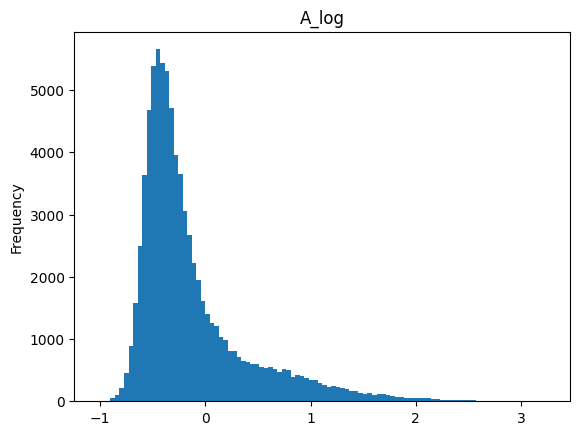

Correlation between B and Y1: -0.02143469016569292
Correlation between B and Y2: 0.6236196444002452


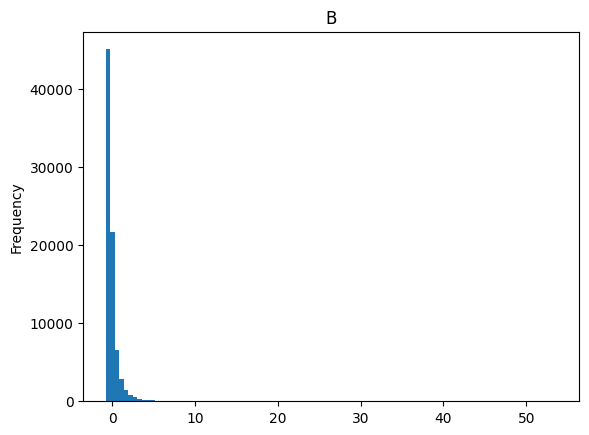

Correlation between B and Y1: -0.02143469016569292
Correlation between B and Y2: 0.6236196444002452


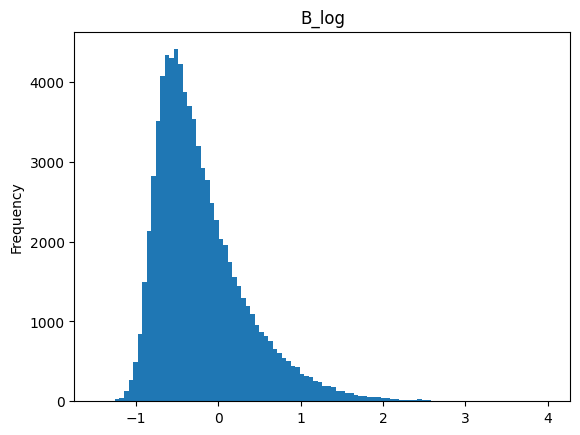

Correlation between C and Y1: 0.6956090355454075
Correlation between C and Y2: -0.009629519042606175


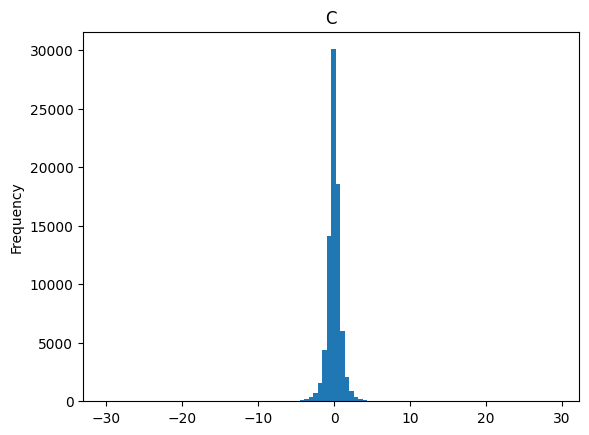

Correlation between C and Y1: 0.6468945347930833
Correlation between C and Y2: 0.14102450441623246


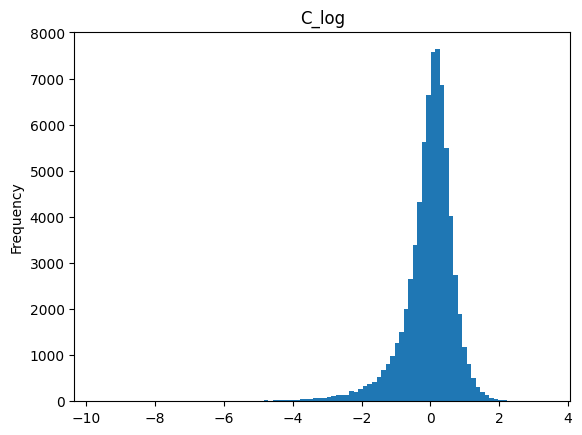

Correlation between D and Y1: -0.016947686349093386
Correlation between D and Y2: 0.6120654627315102


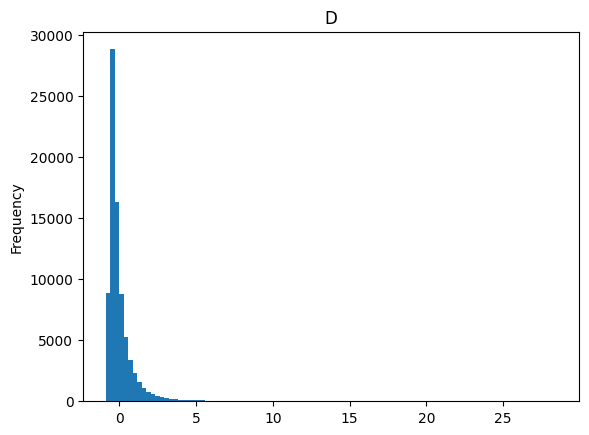

Correlation between D and Y1: -0.016947686349093386
Correlation between D and Y2: 0.6120654627315102


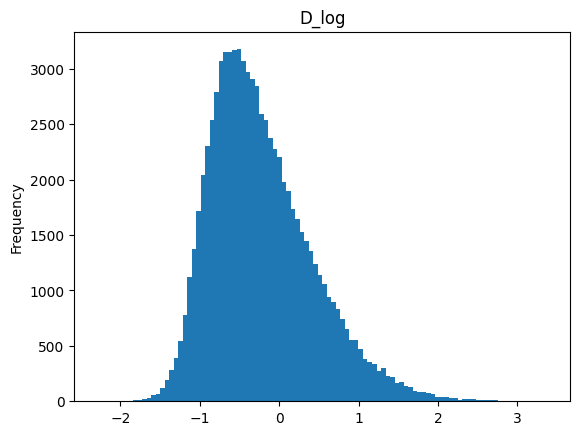

Correlation between E and Y1: 0.7012596304335952
Correlation between E and Y2: -0.016221776585769027


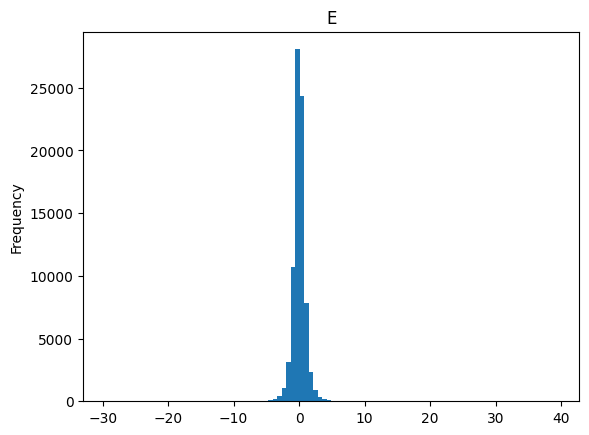

Correlation between E and Y1: 0.6482096422349078
Correlation between E and Y2: 0.13844371340719225


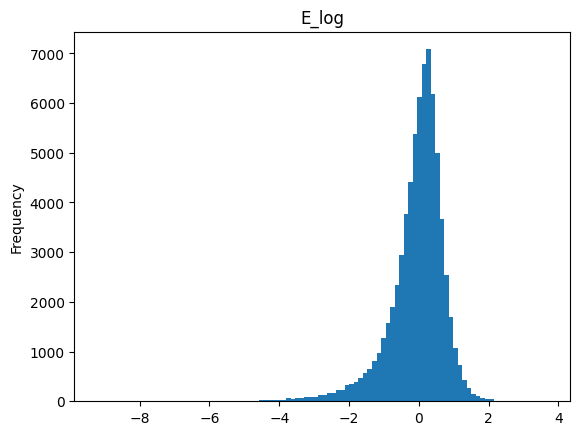

Correlation between F and Y1: -0.017817457814151165
Correlation between F and Y2: 0.5525395519640296


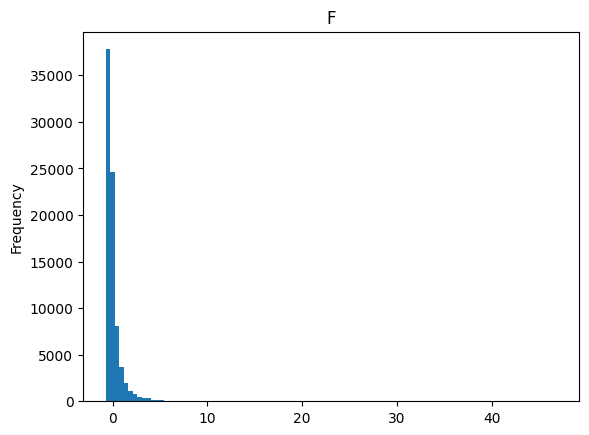

Correlation between F and Y1: -0.017817457814151165
Correlation between F and Y2: 0.5525395519640296


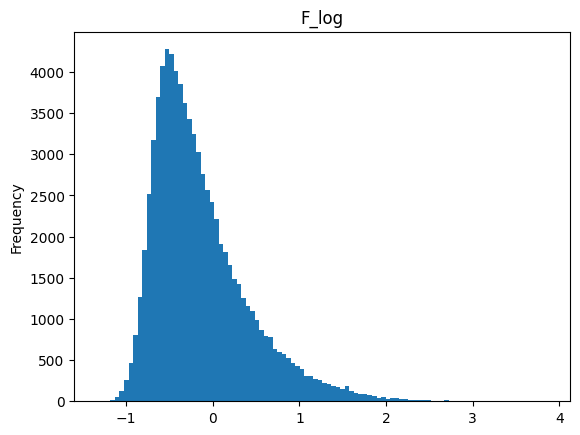

Correlation between G and Y1: 0.7997960016782807
Correlation between G and Y2: -0.013840541181428209


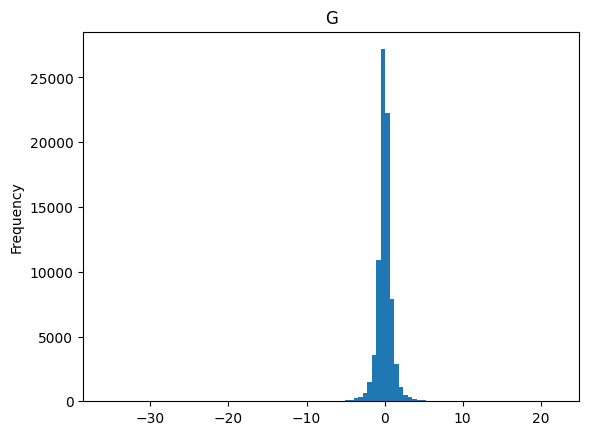

Correlation between G and Y1: 0.7590037876962901
Correlation between G and Y2: 0.16322135618751282


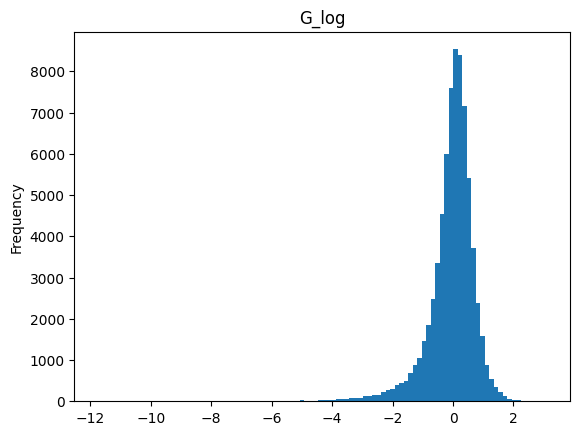

Correlation between H and Y1: 0.6887363319129979
Correlation between H and Y2: -0.011421301196956455


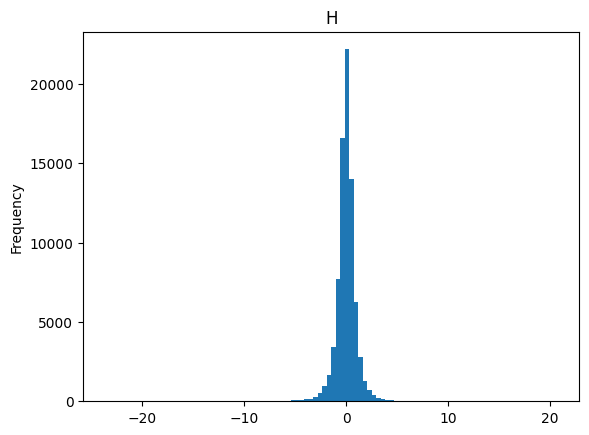

Correlation between H and Y1: 0.6340858253798519
Correlation between H and Y2: 0.14515685928620337


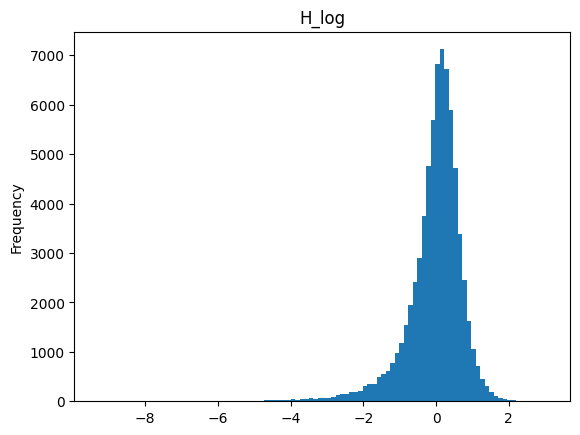

Correlation between I and Y1: -0.032693053383303604
Correlation between I and Y2: 0.5438240053768943


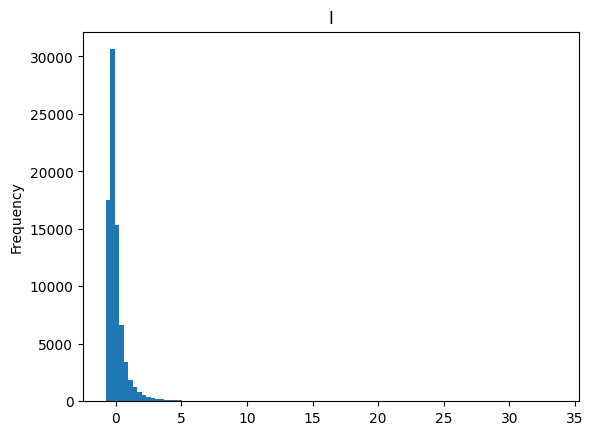

Correlation between I and Y1: -0.032693053383303604
Correlation between I and Y2: 0.5438240053768943


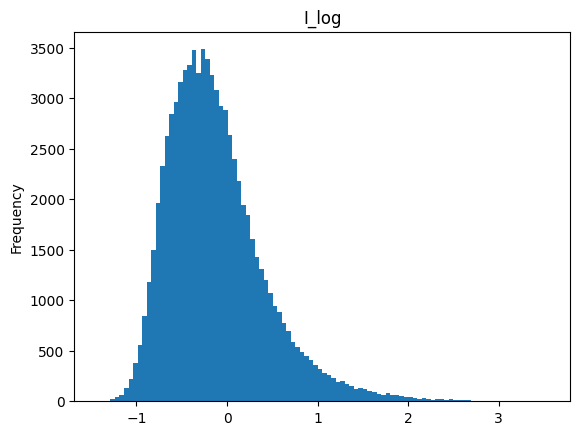

Correlation between J and Y1: 0.7098358275268883
Correlation between J and Y2: -0.01328361706880994


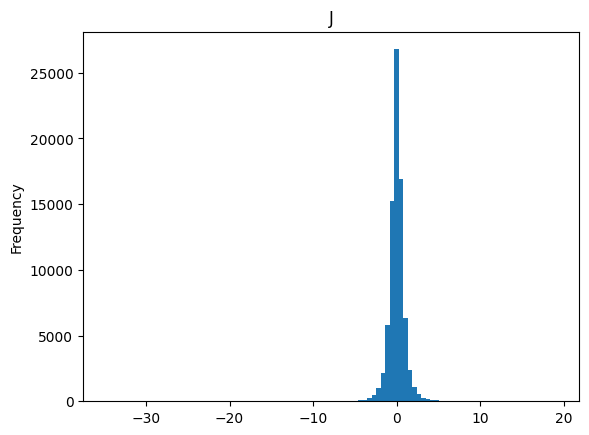

Correlation between J and Y1: 0.6547961569910822
Correlation between J and Y2: 0.14518466404364333


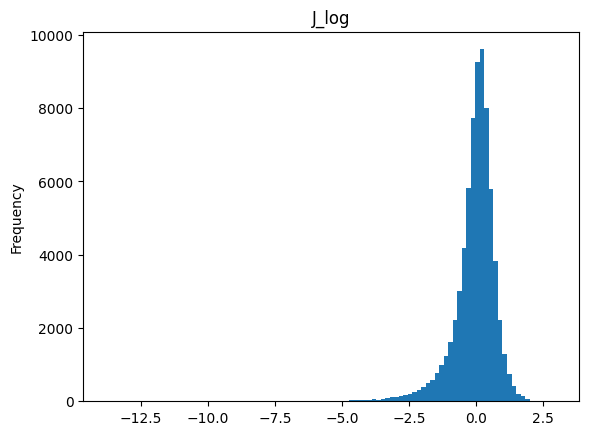

Correlation between K and Y1: -0.024321447783589287
Correlation between K and Y2: 0.6261558241949149


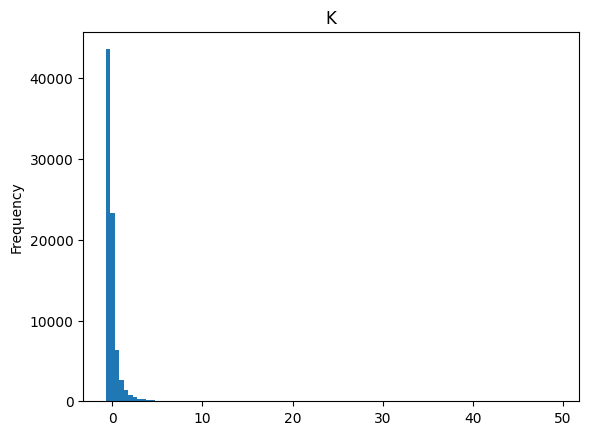

Correlation between K and Y1: -0.024321447783589287
Correlation between K and Y2: 0.6261558241949149


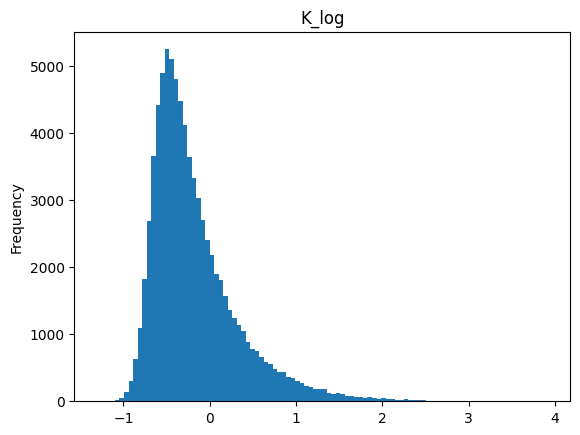

Correlation between L and Y1: -0.023044124737585017
Correlation between L and Y2: 0.5614428124392411


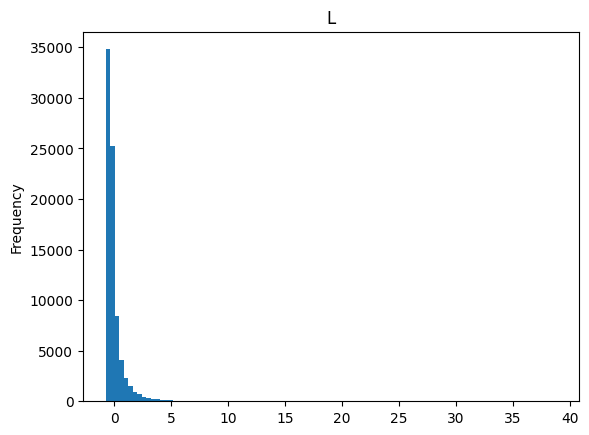

Correlation between L and Y1: -0.023044124737585017
Correlation between L and Y2: 0.5614428124392411


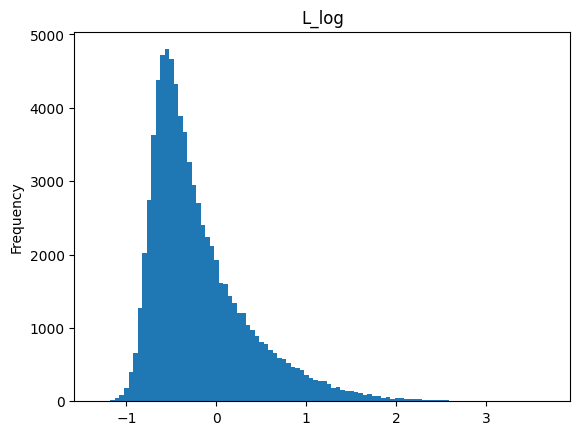

Correlation between M and Y1: 0.7126577204769152
Correlation between M and Y2: -0.015422798106089498


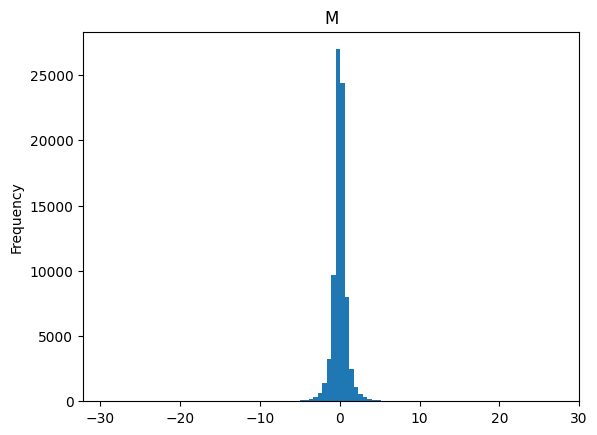

Correlation between M and Y1: 0.6698927617478165
Correlation between M and Y2: 0.12526603949523468


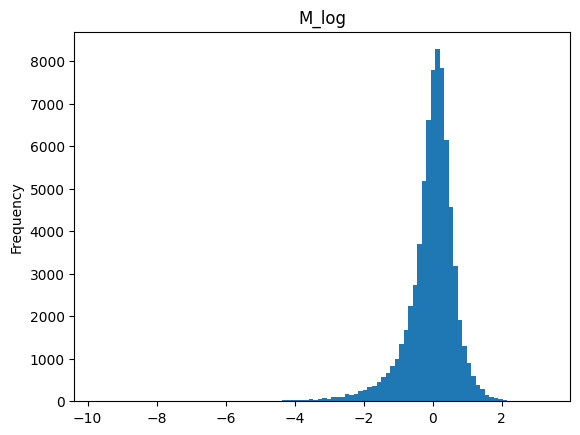

Correlation between N and Y1: 0.6017281568987934
Correlation between N and Y2: -0.013582424579755066


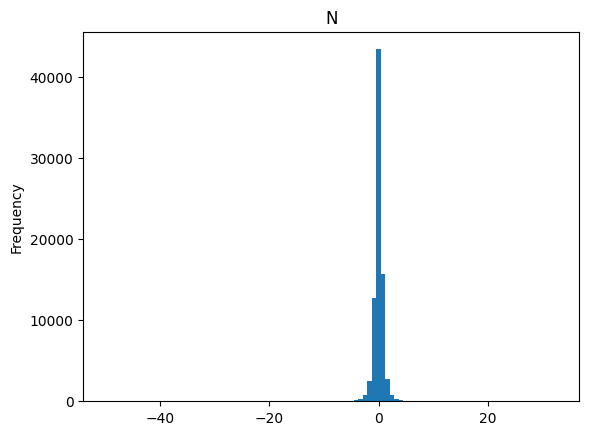

Correlation between N and Y1: 0.5566934695231611
Correlation between N and Y2: 0.10998756920102508


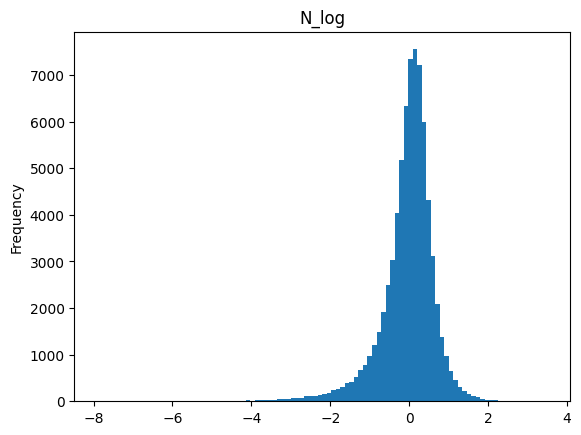

Correlation between Y1 and Y1: 1.0
Correlation between Y1 and Y2: -0.008828781758598246


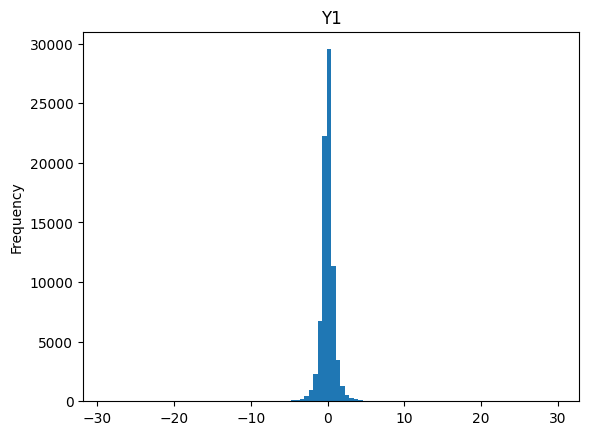

Correlation between Y1 and Y1: 1.0
Correlation between Y1 and Y2: 0.1702662635480771


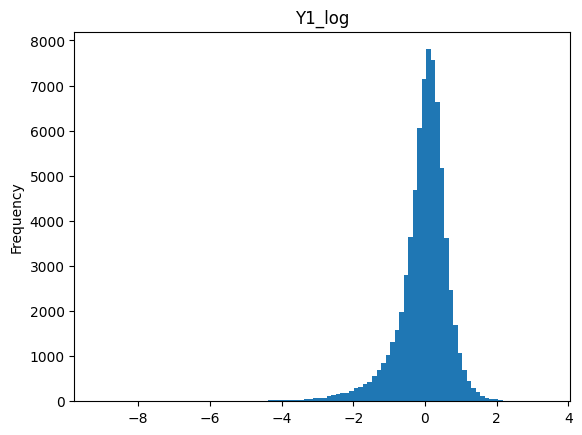

Correlation between Y2 and Y1: -0.008828781758598246
Correlation between Y2 and Y2: 1.0


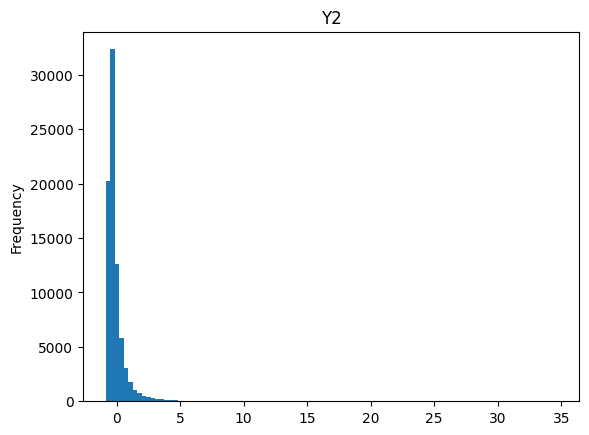

Correlation between Y2 and Y1: -0.008828781758598246
Correlation between Y2 and Y2: 1.0


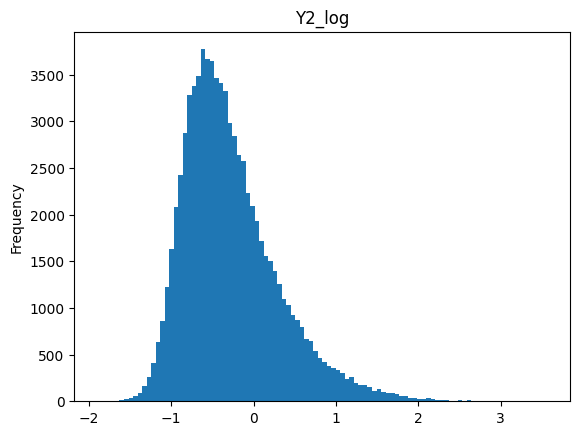

In [5]:
for col in train.columns:
    corr =train[col].corr(train['Y1'], method = 'spearman')
    print(f'Correlation between {col} and Y1: {corr}')
    corr = train[col].corr(train['Y2'], method = 'spearman')
    print(f'Correlation between {col} and Y2: {corr}')
    train[col].plot(kind='hist', title=col, bins= 100)
    plt.show()
    corr =train[col].apply(np.log1p).corr(train['Y1'], method = 'spearman')
    print(f'Correlation between {col} and Y1: {corr}')
    corr = train[col].apply(np.log1p).corr(train['Y2'], method = 'spearman')
    print(f'Correlation between {col} and Y2: {corr}')
    train[col].apply(np.log1p).plot(kind='hist', title=f'{col}_log', bins= 100)
    plt.show()


In [6]:
# Functions: qcut, correlations, splitting, and train/evaluate helpers
def add_qcuts(df, cols=('Y1','Y2'), q=5, labels=None):
    df = df.copy()
    if labels is None:
        labels = [f'q{i+1}' for i in range(q)]
    for col in cols:
        try:
            df[f'{col}_qcut'] = pd.qcut(df[col], q=q, labels=labels, duplicates='drop')
        except Exception as e:
            print(f'Could not qcut {col}:', e)
            df[f'{col}_qcut'] = np.nan
    return df

def correlation_matrix(df, exclude=('time','Y1','Y2'), include_qcut_dummies=False, include_features=None):
    """Compute and plot Spearman correlation matrix.
    If include_features is provided, only those columns (that exist in df) are used plus Y1/Y2 if present.
    When include_qcut_dummies is True, one-hot columns for Y1_qcut and Y2_qcut are appended (prefixed with y1_/y2_).
    """
    if include_features is not None:
        # restrict to provided feature list (keep only columns that exist)
        cols = [c for c in include_features if c in df.columns]
        # ensure targets are present for context
        for t in ['Y1','Y2']:
            if t in df.columns and t not in cols:
                cols.append(t)
    else:
        cols = [c for c in df.columns if c not in exclude]
    # keep only numeric columns to avoid ValueError from non-numeric data
    num_df = df[cols].select_dtypes(include=[np.number]).copy()
    # optionally add one-hot dummies for Y1_qcut and Y2_qcut with prefixes y1_ and y2_
    if include_qcut_dummies:
        for qcol, prefix in [('Y1_qcut','y1_'), ('Y2_qcut','y2_')]:
            if qcol in df.columns:
                dummies = pd.get_dummies(df[qcol], prefix=prefix, dummy_na=False)
                # ensure dummies are numeric
                dummies = dummies.astype(int)
                # align index and concat
                num_df = pd.concat([num_df, dummies.set_index(df.index)], axis=1)
    if num_df.shape[1] < 2:
        print('Not enough numeric columns for correlation matrix. Numeric columns found:', num_df.columns.tolist())
        return pd.DataFrame()
    corr = num_df.corr(method='spearman')
    plt.figure(figsize=(max(6, corr.shape[0]*0.3), max(6, corr.shape[1]*0.3)))
    sns.heatmap(corr, cmap='vlag', center=0, annot=False)
    plt.title('Spearman correlation matrix (selected cols +/- qcut dummies)')
    plt.show()
    return corr
def select_top_predictors(df, target='Y1', candidates=None, top_n=10):
    if candidates is None:
        candidates = [c for c in df.columns if c not in ['time','Y1','Y2','Y1_qcut','Y2_qcut']]
    # keep only numeric and non-constant candidates
    candidates = [c for c in candidates if np.issubdtype(df[c].dtype, np.number) and c != target and df[c].nunique(dropna=True) >= 2]
    rows = []
    for c in candidates:
        try:
            rho = df[c].corr(df[target], method='spearman')
        except Exception:
            rho = np.nan
        rows.append((c, rho))
    df_r = pd.DataFrame(rows, columns=['feature','rho'])
    df_r = df_r.dropna(subset=['rho']).copy()
    if df_r.empty:
        return [], df_r
    df_r['abs_rho'] = df_r['rho'].abs()
    df_r = df_r.sort_values('abs_rho', ascending=False)
    return df_r['feature'].tolist()[:top_n], df_r
def individual_correlations(df, target='Y1', exclude=('time','Y1','Y2')):
    cols = [c for c in df.columns if c not in exclude]
    rows = []
    for col in cols:
        # skip non-numeric columns and constants
        if not np.issubdtype(df[col].dtype, np.number) or df[col].nunique(dropna=True) < 2:
            rho = np.nan
        else:
            try:
                rho = df[col].corr(df[target], method='spearman')
            except Exception:
                rho = np.nan
        strength = 'none'
        if pd.notna(rho):
            ar = abs(rho)
            if ar >= 0.7:
                strength = 'strong'
            elif ar >= 0.4:
                strength = 'moderate'
            elif ar >= 0.2:
                strength = 'weak'
        rows.append({'feature': col, 'spearman_rho': rho, 'strength': strength})
    out = pd.DataFrame(rows).sort_values('spearman_rho', key=lambda s: s.abs(), ascending=False)
    return out

def old_style_target_correlations(df, targets=('Y1','Y2'), exclude=('time','Y1','Y2'), include_log1p=False):
    """Return a DataFrame with Spearman correlations of each (numeric) variable with each target in `targets`.
    If include_log1p is True, also compute correlations after applying np.log1p to the variable (not the target).
    """
    features = [c for c in df.columns if c not in exclude]
    rows = []
    for col in features:
        # handle non-numeric or constant columns by returning NaN
        if not np.issubdtype(df[col].dtype, np.number) or df[col].nunique(dropna=True) < 2:
            vals = {f'rho_{t}': np.nan for t in targets}
            if include_log1p:
                vals.update({f'rho_log1p_{t}': np.nan for t in targets})
        else:
            vals = {}
            for t in targets:
                try:
                    vals[f'rho_{t}'] = df[col].corr(df[t], method='spearman')
                except Exception:
                    vals[f'rho_{t}'] = np.nan
            if include_log1p:
                col_log = np.log1p(df[col])
                for t in targets:
                    try:
                        vals[f'rho_log1p_{t}'] = col_log.corr(df[t], method='spearman')
                    except Exception:
                        vals[f'rho_log1p_{t}'] = np.nan
        row = {'feature': col}
        row.update(vals)
        rows.append(row)
    out = pd.DataFrame(rows)
    # sort by max absolute correlation to any target (if available)
    rho_cols = [c for c in out.columns if c.startswith('rho_')]
    if rho_cols:
        out['max_abs_rho'] = out[rho_cols].abs().max(axis=1)
        out = out.sort_values('max_abs_rho', ascending=False).drop(columns=['max_abs_rho'])
    return out

def qcut_crosstab(df, col1='Y1_qcut', col2='Y2_qcut'):
    return pd.crosstab(df[col1], df[col2], margins=True, normalize=False)

def summary_by_qcut(df, qcol='Y1_qcut', targets=('Y1','Y2')):
    aggs = {}
    for t in targets:
        aggs[t] = ['count','mean','std','min','max']
    return df.groupby(qcol).agg(aggs)

def chronological_split(df, time_col='time', test_size=0.2):
    # Be robust if time_col missing or not comparable - fallback to index order
    if time_col in df.columns:
        try:
            df_sorted = df.sort_values(time_col).reset_index(drop=True)
        except Exception:
            df_sorted = df.reset_index(drop=True)
            print(f"Warning: could not sort by {time_col}; falling back to row order.")
    else:
        df_sorted = df.reset_index(drop=True)
        print(f"Warning: {time_col} not in dataframe; falling back to row order.")
    n_test = int(len(df_sorted) * test_size)
    if n_test < 1:
        n_test = 1
    train_df = df_sorted.iloc[:-n_test].copy()
    test_df = df_sorted.iloc[-n_test:].copy()
    return train_df, test_df


In [7]:
def train_and_evaluate(df, feature_cols, target_col='Y1', model='linear',
                       time_col='time', test_size=0.2, plot=True):
    """
    Add parameter: model can be 'linear', 'tree', 'xgb', 'bma', or 'tabpfn'.
    """
    if not feature_cols:
        raise ValueError('feature_cols is empty; provide at least one numeric feature.')


    train_df, test_df = chronological_split(df, time_col=time_col, test_size=test_size)

    train_feats = train_df[feature_cols].apply(pd.to_numeric, errors='coerce')
    test_feats = test_df[feature_cols].apply(pd.to_numeric, errors='coerce')

    valid_cols = [c for c in feature_cols if not (train_feats[c].isna().all() or test_feats[c].isna().all())]
    if not valid_cols:
        raise ValueError('No valid numeric features after coercion; check your feature columns.')
    if set(valid_cols) != set(feature_cols):
        print('Dropped features:', set(feature_cols) - set(valid_cols))

    X_train = train_feats[valid_cols].values
    y_train = train_df[target_col].values
    X_test = test_feats[valid_cols].values
    y_test = test_df[target_col].values

    if model == 'tabpfn':
        try:
            from tabpfn import TabPFNRegressor
        except ImportError:
            raise ImportError('Install tabpfn: `pip install tabpfn`')
        mdl = TabPFNRegressor(ignore_pretraining_limits=True)
        mdl.fit(X_train, y_train)
        preds = mdl.predict(X_test)

    elif model == 'linear':
        mdl = LinearRegression()
        mdl.fit(X_train, y_train)
        preds = mdl.predict(X_test)

    elif model == 'tree':
        mdl = DecisionTreeRegressor(random_state=0)
        try:
            cv_scores = cross_val_score(mdl, X_train, y_train, scoring='r2', cv=5)
            print(f"DecisionTree CV r2: {np.nanmean(cv_scores):.4f} ± {np.nanstd(cv_scores):.4f}")
        except Exception as e:
            print('DecisionTree cross-val failed:', e)
        mdl.fit(X_train, y_train)
        preds = mdl.predict(X_test)

    elif model == 'xgb':
        from xgboost import XGBRegressor
        mdl = XGBRegressor(n_estimators=100, random_state=0,max_depth = 5,learning_rate  = 0.05, verbosity=0, eval_metric='mphe')
        try:
            cv_scores = cross_val_score(mdl, X_train, y_train, scoring='r2', cv=5)
            print(f"XGBoost CV r2: {np.nanmean(cv_scores):.4f} ± {np.nanstd(cv_scores):.4f}")
        except Exception as e:
            print('XGBoost cross-val failed:', e)
        mdl.fit(X_train, y_train)
        preds = mdl.predict(X_test)
    else:
        raise ValueError('model must be one of: linear, tree, xgb, bma, tabpfn')

    r2 = r2_score(y_test, preds)
    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(test_df[time_col].values, y_test, label='Actual', marker='o')
        plt.plot(test_df[time_col].values, preds, label='Predicted', marker='x')
        plt.xlabel(time_col)
        plt.ylabel(target_col)
        plt.title(f'{model} | R2 = {r2:.4f}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    return {
        'model': mdl,
        'r2': r2,
        'features': valid_cols,
        'preds': preds,
        'actuals': y_test,
        'train_df': train_df,
        'test_df': test_df
    }


Top predictors for Y1: ['G', 'M', 'J', 'E', 'C', 'H', 'N', 'I', 'K', 'L', 'B', 'F', 'D', 'A']


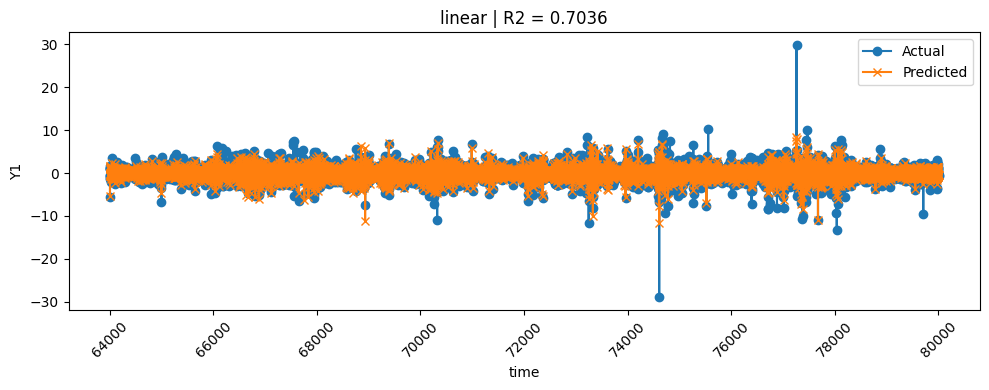

Y1 Linear R2: 0.7035948675195671
DecisionTree CV r2: 0.3298 ± 0.2854


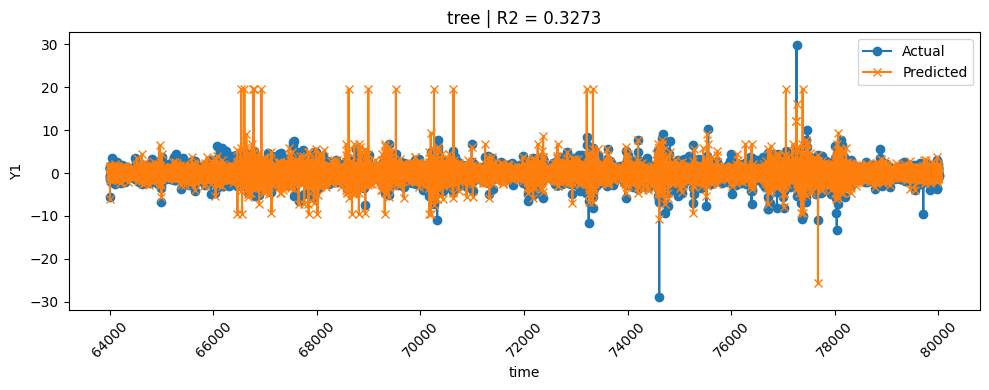

Y1 Tree R2: 0.32728797998291104
XGBoost CV r2: 0.7503 ± 0.0298


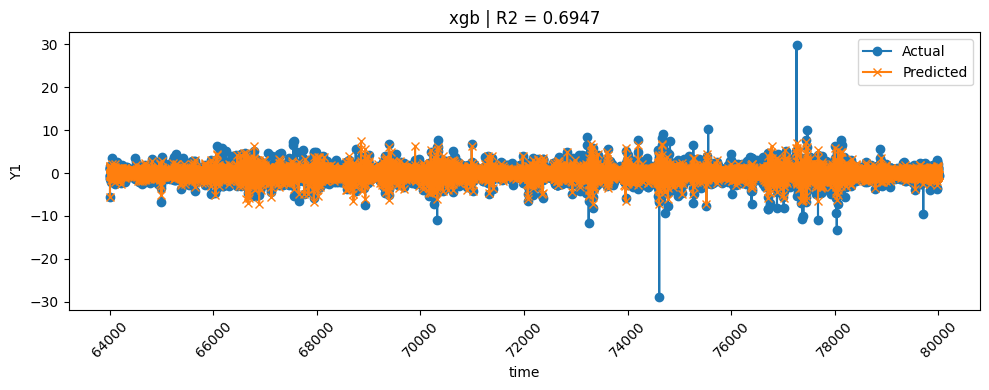

Y1 XGBoost R2: 0.6947266165927901
Top predictors for Y2: ['K', 'B', 'D', 'A', 'L', 'F', 'I', 'E', 'M', 'G', 'N', 'J', 'H', 'C']


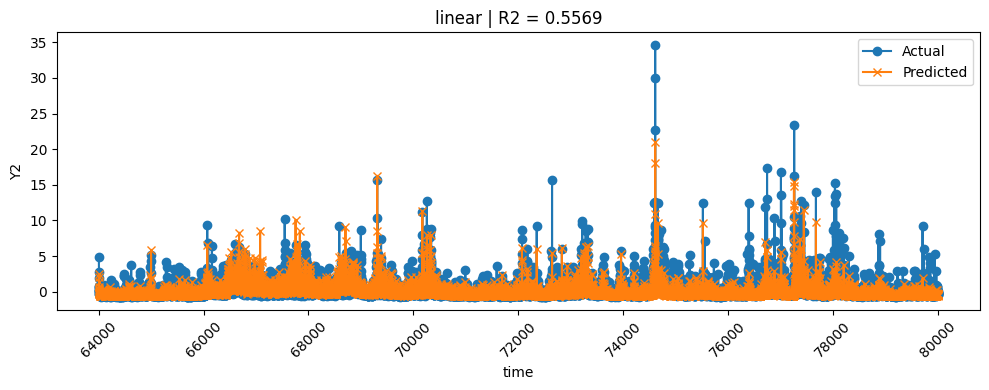

Y2 Linear R2: 0.5568966966398685
DecisionTree CV r2: 0.2000 ± 0.2253


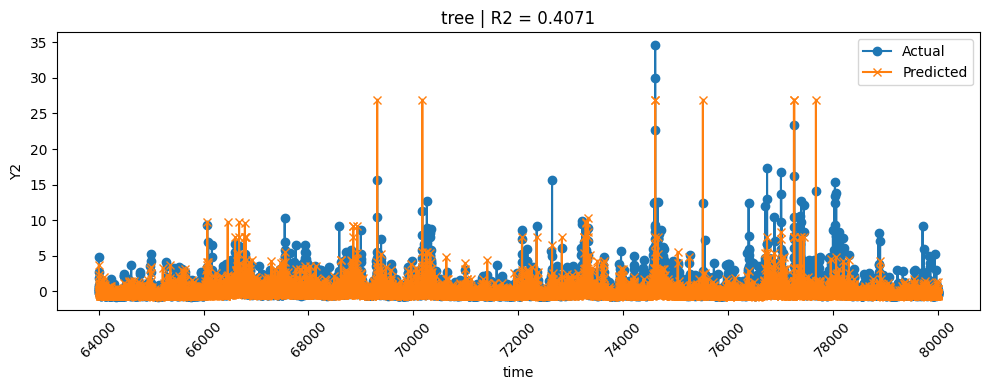

Y2 Tree R2: 0.40709434372867115
XGBoost CV r2: 0.6378 ± 0.1237


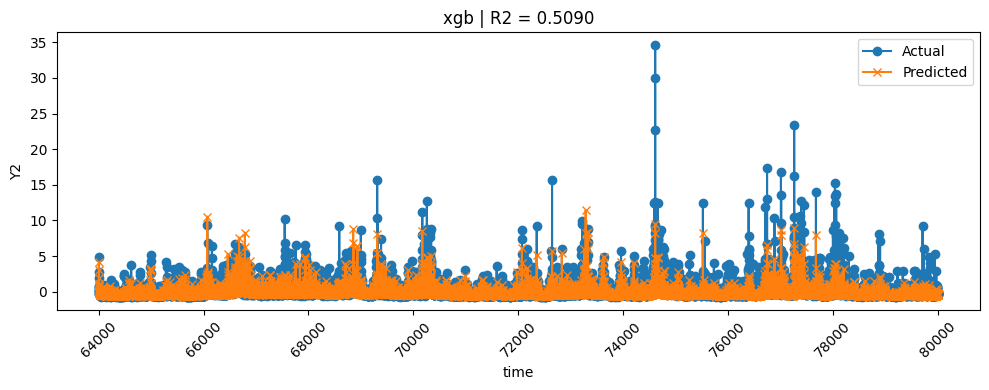

Y2 XGBoost R2: 0.5090497743724676


In [8]:
# Select top predictors and run models for Y1 and Y2 (top_n configurable)
top_n = 14

all_candidate_features = train.drop(columns=['time','Y1','Y2']).columns.tolist()
top_feats_y1, df_r_y1 = select_top_predictors(train, target='Y1', candidates=all_candidate_features, top_n=top_n)
print('Top predictors for Y1:', top_feats_y1)
res_y1_lin = train_and_evaluate(train, top_feats_y1, target_col='Y1', model='linear', time_col='time', test_size=0.2, plot=True)
print('Y1 Linear R2:', res_y1_lin['r2'])

res_y1_tree = train_and_evaluate(train, top_feats_y1, target_col='Y1', model='tree', time_col='time', test_size=0.2, plot=True)
print('Y1 Tree R2:', res_y1_tree['r2'])
try:
    res_y1_xgb = train_and_evaluate(train, top_feats_y1, target_col='Y1', model='xgb', time_col='time', test_size=0.2, plot=True)
    print('Y1 XGBoost R2:', res_y1_xgb['r2'])
except Exception as e:
    print('Skipping Y1 xgboost:', e)

top_feats_y2, df_r_y2 = select_top_predictors(train, target='Y2', candidates=all_candidate_features, top_n=top_n)
print('Top predictors for Y2:', top_feats_y2)
res_y2_lin = train_and_evaluate(train, top_feats_y2, target_col='Y2', model='linear', time_col='time', test_size=0.2, plot=True)
print('Y2 Linear R2:', res_y2_lin['r2'])

res_y2_tree = train_and_evaluate(train, top_feats_y2, target_col='Y2', model='tree', time_col='time', test_size=0.2, plot=True)
print('Y2 Tree R2:', res_y2_tree['r2'])
try:
    res_y2_xgb = train_and_evaluate(train, top_feats_y2, target_col='Y2', model='xgb', time_col='time', test_size=0.2, plot=True)
    print('Y2 XGBoost R2:', res_y2_xgb['r2'])
except Exception as e:
    print('Skipping Y2 xgboost:', e)


In [9]:

X_train = train.drop(columns = ['Y1','Y2','time'])
y_train = train['Y1'].values
mdl = XGBRegressor(n_estimators=100, random_state=0,max_depth = 5,learning_rate  = 0.05, verbosity=0)
cv_scores = cross_val_score(mdl, X_train, y_train, scoring='r2', cv=5)
print(f"XGBoost CV r2: {np.nanmean(cv_scores):.4f} ± {np.nanstd(cv_scores):.4f}")

mdl.fit(X_train, y_train)



XGBoost CV r2: 0.7451 ± 0.0383


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [10]:
y1 = mdl.predict(test.drop(columns = ['time','id']))


In [11]:

X_train = train.drop(columns = ['Y1','Y2','time'])
y_train = train['Y1'].values
mdl = XGBRegressor(n_estimators=100, random_state=0,max_depth = 5,learning_rate  = 0.05, verbosity=0)
cv_scores = cross_val_score(mdl, X_train, y_train, scoring='r2', cv=5)
print(f"XGBoost CV r2: {np.nanmean(cv_scores):.4f} ± {np.nanstd(cv_scores):.4f}")

mdl.fit(X_train, y_train)

XGBoost CV r2: 0.7451 ± 0.0383


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [12]:
X_train

,A,B,C,D,E,F,G,H,I,J,K,L,M,N
0,0.207366,-0.159951,-0.634176,-0.580962,-0.266505,0.060173,-0.475257,-1.486516,-0.332594,-0.671466,-0.226149,-0.187624,-0.780237,-0.785965
1,0.188828,-0.265508,0.042143,-0.550442,-0.132319,-0.185219,0.028295,0.093210,-0.518139,-0.251917,-0.347845,-0.359069,-0.161254,0.020401
2,-0.144261,-0.577142,-0.214634,-0.747391,-0.184255,-0.464831,-0.085181,0.700449,-0.603438,0.197773,-0.566696,-0.580799,0.202726,0.135261
3,0.208982,-0.310449,0.513708,-0.562868,0.742308,-0.305487,0.762246,1.363020,-0.384575,0.525556,-0.348514,-0.428099,0.548993,0.471031
4,0.093320,-0.358156,0.173188,-0.687296,-0.161461,-0.116062,-0.245748,0.863372,-0.655588,-0.263358,-0.557428,-0.481214,0.083602,0.003087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,-0.339802,-0.372094,-0.120952,-0.363438,0.266299,-0.222866,-0.000358,0.470755,-0.412086,-0.332426,-0.374358,-0.251086,-0.058820,0.312828
79996,-0.421921,-0.222554,-0.689585,-0.512266,-0.206562,-0.494450,-0.197705,-0.566908,-0.570731,-1.093729,-0.382964,-0.249580,-0.446410,-0.527049
79997,-0.467038,-0.282018,0.010707,-0.589594,0.067635,-0.410820,0.032695,-0.506164,-0.513340,-0.871582,-0.345584,-0.402364,-0.372984,-0.419894
79998,-0.369710,-0.322384,-0.540326,-0.563206,-0.568736,-0.550024,-0.339077,-0.903734,-0.212600,-0.571418,-0.223712,-0.307187,-1.057527,-2.012514


In [13]:
### Y2
y1_trainpreds = mdl.predict(train.drop(columns = ['time','Y1','Y2']))
train['Y1preds'] =  pd.Series(y1_trainpreds, index=train.index)
X_train = train.drop(columns = ['Y1','Y2','time'])
y_train = train['Y2'].values
mdl = XGBRegressor(n_estimators=100, random_state=0,max_depth = 5,learning_rate  = 0.05, verbosity=0)
cv_scores = cross_val_score(mdl, X_train, y_train, scoring='r2', cv=5)
print(f"XGBoost CV r2: {np.nanmean(cv_scores):.4f} ± {np.nanstd(cv_scores):.4f}")

mdl.fit(X_train, y_train)
test_modifed = test
test_modifed['Y1preds'] = y1
y2preds = mdl.predict(test.drop(columns = ['id','time']))


XGBoost CV r2: 0.5790 ± 0.0957


In [14]:
preds_test = pd.DataFrame({'id': test['id'], 'Y1': y1, 'Y2': y2preds})

In [15]:
preds_test


,id,Y1,Y2
0,1,0.404933,-0.375561
1,2,-0.189386,-0.508931
2,3,-0.208020,-0.336853
3,4,-0.335928,-0.170731
4,5,-0.887708,-0.071172
...,...,...,...
15991,15992,-0.248173,-0.368250
15992,15993,-0.123713,-0.499674
15993,15994,0.286165,-0.431455
15994,15995,0.417996,-0.440790


In [16]:
preds_test.to_csv('Results\y1_preds_mxiao.csv')